# RF (Random Forest)

We will break timeline a bit and jump to random forests instead of introducing perceptrons. The general method of random decision forests was first proposed by Ho only in 1995. RF became really popular approach for tabular dataset due to their simplicity and quite robust behaviour. They are still widely used and for some problems can outperform neural nets.

Before defining random forests we need to explore it's main building block - entropy.

## Entropy

Coined by Claude Shannon in “A Mathematical Theory of Communication” 1948 ([link](http://www.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf)).
Main question: how much useful information are we transmitting?
When we transmit one bit of information we reduce recipients uncertainty by the factor of two.

P.S.: same paper introduced term bit = **bi**nary uni**t**.

Look at the following video:

<iframe width="560" height="315" src="https://www.youtube.com/embed/ErfnhcEV1O8" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Some key points:
- How much information are we getting measured in bits? $- \log_2 (prob) = bits$
- Entropy: $H(p)=-\sum_i p_i \log_2 (p_i)$
- Cross-Entropy: let $p$ - true distribution, $q$ - predicted distribution, then Cross-entropy is
$H(p,q) = -\sum_i p_i \log_2(q_i)$
- If predictions are perfect Cross-entropy is equal to entropy, but usually it is greater than entropy.
- Cross-entropy is often used for ML as a cost function (log-loss) comparing $p$ with $q$.

In [213]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source
from IPython.display import display, SVG

## Iris dataset

Bellow we will work with iris dataset. The idea of the dataset is to find out iris class based on given measurements.

<img src="https://miro.medium.com/max/1100/0*SHhnoaaIm36pc1bd" alt="Iris dataset" style="width: 60%"/>

In [214]:
# Load dataset
iris = load_iris()
df = pd.DataFrame(iris.data, columns = iris.feature_names)
df['class'] = iris.target_names[iris.target]

In [215]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


We have 4 dimensions, but we already know that we can visualize that using PCA.

In [216]:
from sklearn.decomposition import PCA

In [217]:
pca = PCA(2)
pca.fit(df.drop('class', axis=1))

PCA(n_components=2)

In [218]:
X = pca.transform(df.drop('class', axis=1))

<AxesSubplot:xlabel='pc_1', ylabel='pc_2'>

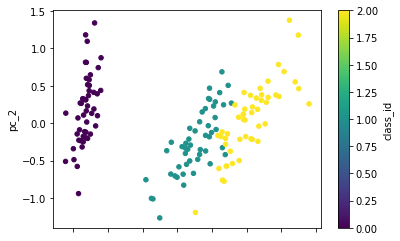

In [221]:
pc = pd.DataFrame(X, columns=['pc_1', 'pc_2'])
pc['class_id'] = iris.target

pc.plot(kind='scatter', x='pc_1', y='pc_2', c='class_id', cmap='viridis')

## Decision Trees

Simple decision tree can be constructed using rule: make a split which **reduces entropy** the most. In a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes.

<img src="https://paper-attachments.dropbox.com/s_4C6E1420D930BE100F0F1313D7A90868E9FB8CAFCB77E86AC4D0FB805D8FC787_1569515384629_image.png" alt="Space deformation" style="width: 70%"/>


Couple facts about decision trees:

- Alternatively you could use Gini impurity as a split criteria, which is defined as $G_i = 1 - \sum_{k=1}^n p_{i,k}^2$ where $p_{i,k}$ is the ratio of class k instances among the training instances in the ith node.
- Finding the optimal tree is known to be an NP-Complete problem $O(\exp (m))$.
- Decision Trees are very sensitive to small variations in the training data.
- Decision Trees can easily over-fit if there is high number of columns! 

Let's try this out on iris dataset. First we will need to make train/test split.

In [222]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('class', axis=1), df['class'],
    test_size=0.3, random_state=42)

Let's fit entropy based tree on iris dataset.

----------------------------------------------------------------------
Tree for max_dept = 1

Correctly identified on train set - 64.76%, on test set - 71.11%


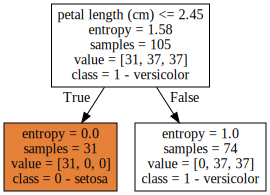

----------------------------------------------------------------------
Tree for max_dept = 2

Correctly identified on train set - 94.29%, on test set - 97.78%


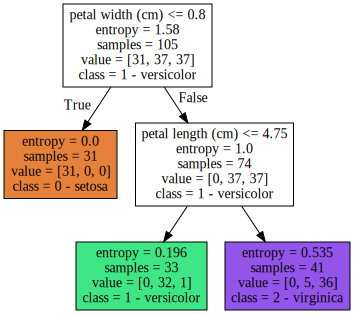

----------------------------------------------------------------------
Tree for max_dept = 3

Correctly identified on train set - 96.19%, on test set - 100.00%


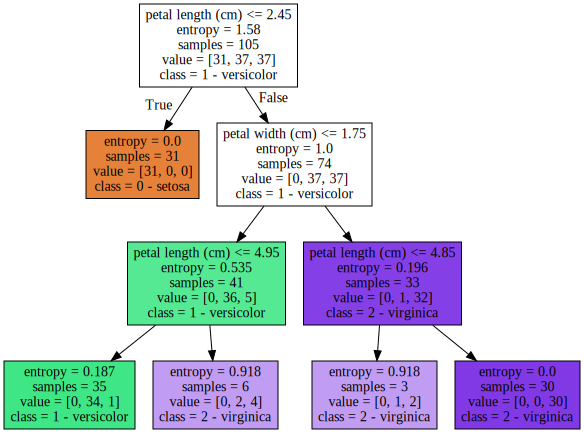

In [224]:
for max_depth in range(1, 4):
    print('-' * 70 + '\nTree for max_dept = {0}\n'.format(max_depth))
    tree = DecisionTreeClassifier(max_depth=max_depth, criterion='entropy')
    # Fit on train data
    tree.fit(X_train, y_train)

    # Make prediction and evaluate performance
    pred_train = tree.predict(X_train)
    pred_test = tree.predict(X_test)
    print('Correctly identified on train set - {0:.02%}, on test set - {1:.02%}'.format(
        (pred_train == y_train).mean(),
        (pred_test == y_test).mean()))

    # Make a nice plot
    graph = Source(export_graphviz(tree, out_file=None, filled = True,
                                   feature_names=df.drop('class', axis=1).columns,
                                   class_names=['0 - setosa', '1 - versicolor', '2 - virginica']))
    display(SVG(graph.pipe(format='svg')))

As we can see simple decision tree works quite good for iris dataset.

### Larger dataset and overfit example

Let's load another legendary dataset containing classification problem. If you are interested in dataset details see [UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).

In [225]:
from sklearn.datasets import load_breast_cancer

# Load dataset
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
df['class'] = cancer.target_names[cancer.target]

# Train/test mask
np.random.seed(42)
mask = np.random.rand(df.shape[0]) < 0.8

df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [226]:
df.groupby('class').size()

class
benign       357
malignant    212
dtype: int64

As before we will fit multiple trees with different max_depth's. This time let's plot performance on train and test sets.

<AxesSubplot:title={'center':'Accuracy for different max_depth values'}>

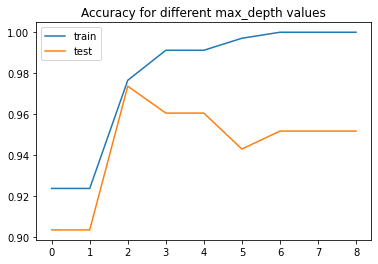

In [229]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('class', axis=1), df['class'],
    test_size=0.4, random_state=42)

L = []
for max_depth in range(1, 10):
    tree = DecisionTreeClassifier(max_depth=max_depth, criterion='entropy', random_state=42)
    # Fit on train data
    tree.fit(X_train, y_train)

    # Make prediction and evaluate performance
    pred_train = tree.predict(X_train)
    pred_test = tree.predict(X_test)
    L.append([(pred_train == y_train).mean(),
              (pred_test == y_test).mean()])

pd.DataFrame(L, columns=['train', 'test']).plot(
    title='Accuracy for different max_depth values')

Notice that as the depth increases, we tend to get very strangely shaped classification regions. Such overfitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from. Another way to see this overfitting is to look at models trained on different subsets of the data.

How can we prevent it in this case?

## Ensembles

The notion that multiple overfitting estimators can be combined to reduce the effect of overfitting is what underlies an ensemble method called bagging. Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which overfits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a random forest.

<img src="https://paper-attachments.dropbox.com/s_4C6E1420D930BE100F0F1313D7A90868E9FB8CAFCB77E86AC4D0FB805D8FC787_1569583935206_image.png"  style="width: 50%"/>

<img src="https://paper-attachments.dropbox.com/s_4C6E1420D930BE100F0F1313D7A90868E9FB8CAFCB77E86AC4D0FB805D8FC787_1569583987571_image.png"  style="width: 50%"/>

Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

Ensemble methods lead to similar bias but a lower variance.

<img src="https://nvsyashwanth.github.io/machinelearningmaster/assets/images/bias_variance.jpg" style="width: 40%"/>

### Random forests

You can make multiple trees by choosing sub-sample of features (usually $\sqrt{m}$) and taking bootstrapped samples. Then just let trees vote for decision.

<img src="https://victorzhou.com/media/random-forest-post/random-forest.png" style="width: 60%"/>

Hard voting averages predictions, soft voting averages predicted probabilities instead. 

In [233]:
from sklearn.ensemble import BaggingClassifier

# Defining the base estimator
base = DecisionTreeClassifier(max_depth=5, splitter='best',
                    max_features='sqrt', criterion='entropy')

# Create Random Forest 
ensemble = BaggingClassifier(base_estimator=base, n_estimators=1000,
                             bootstrap=True)

In [234]:
%%time

ensemble.fit(X_train, y_train)
pred_train = ensemble.predict(X_train)
pred_test = ensemble.predict(X_test)
    
print('Correctly identified on train set - {0:.02%}, on test set - {1:.02%}\n'.format(
    (pred[mask] == df[mask]['class']).mean(),        # train set
    (pred[~mask] == df[~mask]['class']).mean()))     # test set

Correctly identified on train set - 100.00%, on test set - 96.06%

CPU times: user 2.01 s, sys: 21.4 ms, total: 2.04 s
Wall time: 2.07 s


In realiy you should use `RandomForestClassifier` implementation instead. Lines above are only for illustation purposes.

In [235]:
from sklearn.ensemble import RandomForestClassifier

In [236]:
%%time

rf = RandomForestClassifier(1000)
rf.fit(df[mask].drop('class', axis=1), df[mask]['class'])
pred = rf.predict(df.drop('class', axis=1))

print('Correctly identified on train set - {0:.02%}, on test set - {1:.02%}\n'.format(
    (pred_train == y_train).mean(),
    (pred_test == y_test).mean()))

Correctly identified on train set - 99.71%, on test set - 97.37%

CPU times: user 1.73 s, sys: 13.6 ms, total: 1.75 s
Wall time: 1.76 s


**Note:** there are other variations of boosted trees, for example ExtraTrees can be constructed by setting splitter to random and bootstrap to False. ExtraTrees are usually faster to train, but Random Forests are more well known, just try them both and see which works better for problem at hand.

### Task

Try to use `sklearn.ensemble.RandomForestClassifier` for iris dataset. Use sklearn implementation.

In [140]:
# Load dataset
iris = load_iris()
df = pd.DataFrame(iris.data, columns = iris.feature_names)
df['class'] = iris.target_names[iris.target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('class', axis=1), df['class'],
    test_size=0.5, random_state=42)

# TODO: train RF and compare results to the ones we had above


I suggest to try it out on your own before looking at the answer given bellow.

#### Answer

In [167]:
from sklearn.ensemble import RandomForestClassifier

In [185]:
df['sepal area'] = df['sepal length (cm)'] * df['sepal width (cm)']
df['petal area'] = df['petal length (cm)'] * df['petal width (cm)']
df['simetry'] = df['sepal area'] / df['petal area']

In [186]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('class', axis=1), df['class'],
    test_size=0.5, random_state=42)

In [188]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=2)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_estimators=1000)

In [189]:
pred = rf.predict(X_test)
acc = np.mean(pred == y_test)
print(f'Accuracy {acc:.02%}')

Accuracy 98.67%


## Neat tricks

### Confusion matrix

Thisis a neat way to see where your model is making mistakes.

In [193]:
from sklearn.metrics import confusion_matrix

In [199]:
pd.DataFrame(confusion_matrix(y_test, pred),
             columns=rf.classes_, index=rf.classes_).style.background_gradient()

,setosa,versicolor,virginica
setosa,29,0,0
versicolor,0,23,0
virginica,0,1,22


### Feature importance

It is easy to check which features are most important - ones which were used in most trees or/and gave highest information gain overall.

In [204]:
pd.DataFrame(rf.feature_importances_,
             index=df.drop('class', axis=1).columns).style.background_gradient()

,0
sepal length (cm),0.052815
sepal width (cm),0.021418
petal length (cm),0.205589
petal width (cm),0.209287
sepal area,0.025440
petal area,0.239397
simetry,0.246055


## A note on decision boundaries

Let's generate some data blobs.

In [208]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

tree = DecisionTreeClassifier()
tree.fit(X, y)

rf = RandomForestClassifier(n_estimators=500, max_depth=2)
rf.fit(X, y)

RandomForestClassifier(max_depth=2, n_estimators=500)

Look at overfitting here, make decision boundary plots.

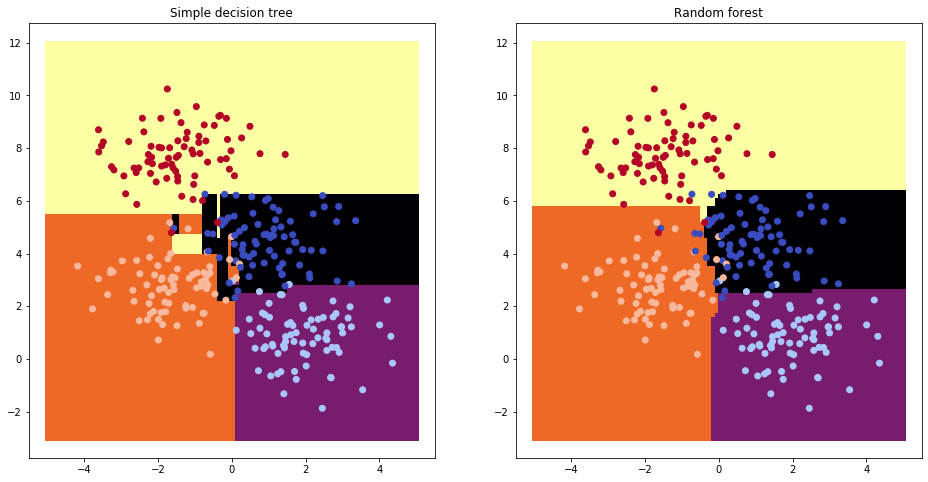

In [20]:
mesh = np.transpose([np.tile(np.linspace(-5, 5, 100), 100),
                     np.repeat(np.linspace(-3, 12, 100), 100)])

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.scatter(mesh[:, 0], mesh[:, 1], c=tree.predict(mesh), marker='s', s=20, cmap='inferno')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
plt.title('Simple decision tree')
plt.subplot(122)
plt.scatter(mesh[:, 0], mesh[:, 1], c=rf.predict(mesh), marker='s', s=20, cmap='inferno')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
plt.title('Random forest')
plt.show()

Make sure that you understand why those decision boundaries look this way.

By the way, RF with standard param set will not look so nice, play around.

## MNIST

The [MNIST database](http://yann.lecun.com/exdb/mnist/) contains handwritten digits and has a training set of 60,000 examples, and a test set of 10,000 examples. It is legendary dataset crated by LeCun group in 1999.

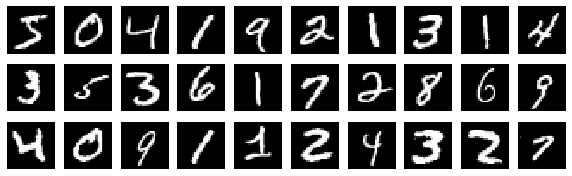

In [21]:
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
# Normalize
X_train = X_train / 255
X_test = X_test / 255

plt.figure(figsize=(10, 3))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.axis('off')
plt.show()

X_train = X_train.reshape((60000, 28*28))
X_test = X_test.reshape((10000, 28*28))

In [22]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, pred)

0.9698

In [24]:
import pandas as pd
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_test, pred), columns=range(10), index=range(10)).style.background_gradient()

,0,1,2,3,4,5,6,7,8,9
0,968,0,0,1,0,3,5,1,2,0
1,0,1124,1,4,0,2,2,0,1,1
2,6,0,999,5,3,0,3,9,7,0
3,0,0,11,971,0,10,0,9,6,3
4,1,0,0,0,953,0,6,0,3,19
5,4,0,1,12,4,856,6,2,6,1
6,5,3,0,0,3,3,941,0,3,0
7,2,2,19,0,0,0,0,991,2,12
8,5,0,4,8,2,7,3,3,934,8
9,6,4,3,10,10,3,1,5,6,961


True labels are on the left and predicted ones on the top. Quick glimpse gives you insightes like - RF makes most mistakes while identifying actual 7 as 2 and actual 4 as 9. What other insights can you give?

Soon we will see that using neural networks we can avoid some of these mistakes, but key insight here is that RF is good method even for complex tasks as this one.

## Whats next?

There are many variations of Random Forests you can explore, to name a few:
- [ExtraTrees](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)
- [XGBoost](https://xgboost.readthedocs.io/en/latest/)
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/)

Up to the day of writing XGboost is still a leading method for tabular problems, but as we will see deep learning will beat them at unstructured data. Basic idea of XGBoost: fit next decision tree on residual errors made by the previous predictor, thus trying to fix them.

1. Fit $\text{tree}_0$ on $X$ and $y_0=y$ and make predictions $y_1$. Set $i=1$.
2. Fit $\text{tree}_i$ to predict residuals $y_{i-1} - y_i$ given $X$ and make predictions $y_{i+1}$.
3. Increment $i$ and jump back to step 2.


## (Re) Sources:
- Claude Shannon “A Mathematical Theory of Communication” 1948 ([link](http://www.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf)).
- Nice [video](https://youtu.be/ErfnhcEV1O8) about Entropy 
- Medium [post](https://towardsdatascience.com/must-know-information-theory-concepts-in-deep-learning-ai-e54a5da9769d) about Entropy
- Logistic regression from scratch ([medium post](https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac))
